In [58]:
from torch.utils import data
from torchvision.transforms import transforms
import os
#from multiprocessing.pool import Pool
import cv2
import numpy as np
#from degradation_code.utils_de import *
from PIL import Image

In [59]:
def imread(file_path, c=None):
    if c is None:
        im = cv2.imread(file_path)
    else:
        im = cv2.imread(file_path, c)

    if im is None:
        raise 'Can not read image'

    if im.ndim == 3 and im.shape[2] == 3:
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    return im


def imwrite(file_path, image):
    if image.ndim == 3 and image.shape[2] == 3:
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    cv2.imwrite(file_path, image)

def fold_dir(folder):
    if not os.path.exists(folder):
        os.makedirs(folder)
    return folder

Read image as a cv2 type ([height, width, 3] ~ [0, 255]) and write image.

In [60]:
def get_mask_BZ(img):
    if img.ndim == 3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray_img = img
    threhold = np.mean(gray_img)/3-5
    _, mask = cv2.threshold(gray_img, max(0, threhold), 1, cv2.THRESH_BINARY)
    nn_mask = np.zeros((mask.shape[0]+2, mask.shape[1]+2), np.uint8)
    new_mask = (1-mask).astype(np.uint8)
    #  cv::floodFill(Temp, Point(0, 0), Scalar(255));
    # _,new_mask,_,_ = cv2.floodFill(new_mask, nn_mask, [(0, 0),(0,new_mask.shape[0])], (0), cv2.FLOODFILL_MASK_ONLY)
    _, new_mask, _, _ = cv2.floodFill(new_mask, nn_mask, (0, 0), (0), cv2.FLOODFILL_MASK_ONLY)
    _, new_mask, _, _ = cv2.floodFill(new_mask, nn_mask, (new_mask.shape[1]-1, new_mask.shape[0]-1), (0), cv2.FLOODFILL_MASK_ONLY)
    mask = mask + new_mask
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (20,  20))
    mask = cv2.erode(mask, kernel)
    mask = cv2.dilate(mask, kernel)
    return mask

Generate a sketch of the fundus mask.

In [61]:
def _get_center_by_edge(mask):
    center = [0, 0]
    x = mask.sum(axis=1)
    center[0] = np.where(x > x.max()*0.95)[0].mean()
    x = mask.sum(axis=0)
    center[1] = np.where(x > x.max()*0.95)[0].mean()
    return center

Confirm the center of the fundus mask.

In [62]:
def _get_radius_by_mask_center(mask, center):
    mask = mask.astype(np.uint8)
    ksize = max(mask.shape[1]//400*2+1, 3)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (ksize, ksize))
    mask = cv2.morphologyEx(mask, cv2.MORPH_GRADIENT, kernel)
    # radius=
    #cv2.imshow('1',mask)
    #cv2.waitKey(0)
    index = np.where(mask > 0)
    d_int = np.sqrt((index[0]-center[0])**2+(index[1]-center[1])**2)
    b_count = np.bincount(np.ceil(d_int).astype(np.int_))
    radius = np.where(b_count > b_count.max()*0.995)[0].max()
    return radius

Confirm the radius of the fundus mask.

In [63]:
def _get_circle_by_center_bbox(shape, center, bbox, radius):
    center_mask = np.zeros(shape=shape).astype('uint8')
    tmp_mask = np.zeros(shape=bbox[2:4])
    center_tmp = (int(center[0]), int(center[1]))
    center_mask = cv2.circle(center_mask, center_tmp[::-1], int(radius), (1), -1)
    # center_mask[bbox[0]:bbox[0]+bbox[2],bbox[1]:bbox[1]+bbox[3]]=tmp_mask
    # center_mask[bbox[0]:min(bbox[0]+bbox[2],center_mask.shape[0]),bbox[1]:min(bbox[1]+bbox[3],center_mask.shape[1])]=tmp_mask
    return center_mask

Confirm the fundus mask.

In [64]:

def get_mask(img):
    if img.ndim == 3:
        #raise 'image dim is not 3'
        g_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    elif img.ndim == 2:
        g_img = img.copy()
    else:
        raise 'image dim is not 1 or 3'
    h, w = g_img.shape
    shape = g_img.shape[0:2]
    g_img = cv2.resize(g_img, (0, 0), fx=0.5, fy=0.5)
    tg_img = cv2.normalize(g_img, None, 0, 255, cv2.NORM_MINMAX)
    tmp_mask = get_mask_BZ(tg_img)
    center = _get_center_by_edge(tmp_mask)
    #bbox=_get_bbox_by_mask(tmp_mask)
    radius = _get_radius_by_mask_center(tmp_mask, center)
    #resize back
    center = [center[0]*2, center[1]*2]
    radius = int(radius*2)
    s_h = max(0, int(center[0] - radius))
    s_w = max(0, int(center[1] - radius))
    bbox = (s_h, s_w, min(h-s_h, 2 * radius), min(w-s_w, 2 * radius))
    tmp_mask = _get_circle_by_center_bbox(shape, center, bbox, radius)
    return tmp_mask, bbox, center, radius


Generate the fundus mask and other parameters.

In [65]:
def remove_back_area(img, bbox=None, border=None):
    image = img
    if border is None:
        border = np.array((bbox[0], bbox[0]+bbox[2], bbox[1], bbox[1]+bbox[3], img.shape[0], img.shape[1]), dtype=np.int_)
    image = image[border[0]:border[1], border[2]:border[3], ...]
    return image, border

def supplemental_black_area(img, border=None):
    image = img
    if border is None:
        h, v = img.shape[0:2]
        max_l = max(h, v)
        if image.ndim > 2:
            image = np.zeros(shape=[max_l, max_l, img.shape[2]], dtype=img.dtype)
        else:
            image = np.zeros(shape=[max_l, max_l], dtype=img.dtype)
        border = (int(max_l/2-h/2), int(max_l/2-h/2)+h, int(max_l/2-v/2), int(max_l/2-v/2)+v, max_l)
    else:
        max_l = border[4]
        if image.ndim > 2:
            image = np.zeros(shape=[max_l, max_l, img.shape[2]], dtype=img.dtype)
        else:
            image = np.zeros(shape=[max_l, max_l], dtype=img.dtype)
    image[border[0]:border[1], border[2]:border[3], ...] = img
    return image, border

In [66]:
def mask_image(img, mask):
    img[mask <= 0, ...] = 0
    return img

def process_without_gb(img):
    # preprocess images
    #   img : origin image
    #   tar_height: height of tar image
    # return:
    #   result_img: preprocessed image
    #   borders: remove border, supplement mask
    #   mask: mask for preprocessed image
    borders = []
    mask, bbox, center, radius = get_mask(img)
    r_img = mask_image(img, mask)
    r_img, r_border = remove_back_area(r_img, bbox=bbox)
    mask, _ = remove_back_area(mask, border=r_border)
    borders.append(r_border)
    r_img, sup_border = supplemental_black_area(r_img)
    mask, _ = supplemental_black_area(mask, border=sup_border)
    borders.append(sup_border)
    return r_img, borders, (mask*255).astype(np.uint8)

The whole process of generating fundus mask and removing black area.

In [67]:
def rb_and_resize(img_path,img_save_path,mask_save_path):
    tra=transforms.Compose([
                transforms.Resize([512,512])
                    ])

    img=imread(img_path)
    print(img.shape)
    rimg,bd,rmask=process_without_gb(img)
    #rimg = cv2.cvtColor(rimg, cv2.COLOR_RGB2BGR)

    rimg=tra(Image.fromarray(rimg.astype(np.uint8)))
    rmask=tra(Image.fromarray(rmask.astype(np.uint8)))
    #rimg.show()
    if img_save_path != None:
        rimg.save(img_save_path)
    #rmask.save
    rmask.save(mask_save_path)
    return rimg, rmask

A convenient function to do the whole pre-processing. Transform the result images from cv2 to PIL.Image type to save them.
input
    img_path : the path of the original fundus image
    img_save_path : the path you want to save the processed image
    mask_save_path : the path you want to save the generated mask
return
    (optional) rimg, rmask : the pre-processed image and mask


(1632, 2464, 3)
done


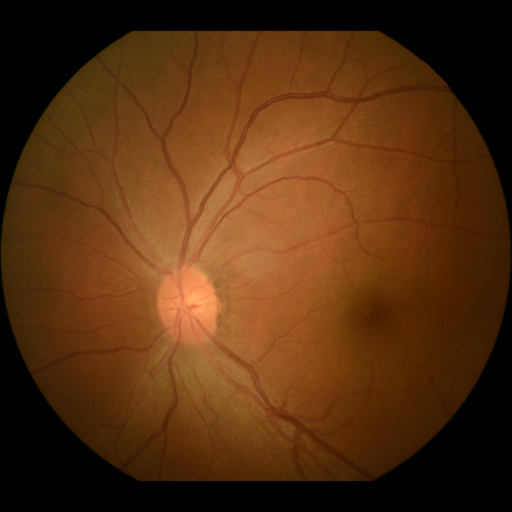

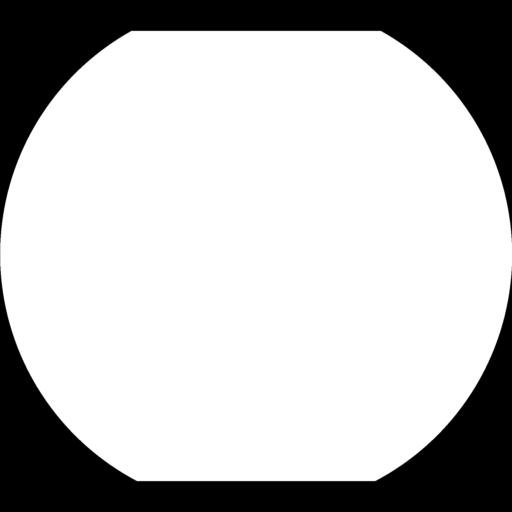

In [71]:
if __name__ == '__main__':
    #D:\lec\ML\GDRNet\GDRBench_data\codes\show.jpg
    imgpath = './show.jpg'
    img_save_path = '.rimg1.jpg'
    mask_save_path = './rmsk1.jpg'
    rimg, rmask = rb_and_resize(imgpath, img_save_path, mask_save_path)
    print('done')
    display(rimg)
    display(rmask)
    